In [62]:
# nltk.download('stopwords')

In [63]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [64]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [65]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [67]:
df = pd.read_csv("usnewspaper_china.csv", header=None,)

In [68]:
data = df[0].dropna().tolist()

In [69]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_3918/2869499433.py:2: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [70]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

In [71]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [72]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [73]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

In [74]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [75]:
data_lemmatized[2][:10]

['image',
 'make',
 'video',
 'chinese',
 'spokesperson',
 'gesture',
 'speak',
 'medium',
 'affair']

## Bigrams and Trigrams

In [76]:
bigram = Phrases(data_lemmatized, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [77]:
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops]

In [78]:
data_with_phrases[1][:10]

['cookie_preferences',
 'cookie_list',
 'cookie_list',
 'cookie',
 'small_piece',
 'data',
 'text_file',
 'website',
 'visited',
 'user_asks']

In [90]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_above=0.5) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_lemmatized#data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [91]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=25, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto',
                per_word_topics=True)

In [92]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 14055
Number of documents: 10000


In [93]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [94]:
# Print the Keyword
#print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [95]:
lda_model.print_topics()

[(13,
  '0.073*"que" + 0.033*"unido" + 0.033*"por" + 0.025*"estado" + 0.022*"este" + 0.018*"segun" + 0.017*"estadounidense" + 0.017*"paise" + 0.012*"millone" + 0.010*"puede"'),
 (22,
  '0.030*"cookie" + 0.021*"loan" + 0.019*"use" + 0.018*"country" + 0.016*"debt" + 0.016*"website" + 0.014*"browser" + 0.010*"site" + 0.008*"pay" + 0.008*"take"'),
 (15,
  '0.047*"philippine" + 0.029*"vessel" + 0.027*"water" + 0.026*"ship" + 0.021*"dispute" + 0.019*"claim" + 0.012*"maritime" + 0.012*"shoal" + 0.011*"territorial" + 0.011*"boat"'),
 (21,
  '0.046*"die" + 0.039*"covid" + 0.018*"death" + 0.014*"health" + 0.012*"hospital" + 0.011*"und" + 0.011*"people" + 0.011*"virus" + 0.010*"m" + 0.010*"government"'),
 (8,
  '0.024*"panda" + 0.017*"new" + 0.016*"follow" + 0.015*"study" + 0.015*"researcher" + 0.014*"zoo" + 0.013*"analysis" + 0.013*"specie" + 0.013*"bit" + 0.011*"giant"'),
 (18,
  '0.043*"space" + 0.015*"satellite" + 0.014*"station" + 0.014*"mission" + 0.011*"flight" + 0.011*"launch" + 0.009*"fi

In [96]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [97]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [98]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.019735  0.124900       1        1  15.680882
10    -0.041909  0.039935       2        1  10.832014
7     -0.099813  0.057651       3        1   8.971249
23     0.034268  0.084091       4        1   8.426813
3     -0.174751  0.003972       5        1   7.327605
0      0.016986  0.111903       6        1   6.485827
1      0.101889  0.126415       7        1   4.271572
16     0.132901  0.143618       8        1   4.178231
5     -0.174880 -0.019817       9        1   3.721967
6     -0.040040  0.024613      10        1   3.336651
2     -0.214903 -0.036933      11        1   3.087126
11     0.045436  0.003055      12        1   2.419151
22    -0.051779 -0.008046      13        1   2.166353
20    -0.201670 -0.047869      14        1   2.068230
14     0.063973 -0.071661      15        1   2.051681
4     -0.174065 -0.097165      16        1   2.041784
21     0.015203 -0.043941      17        1   1.974531
19     0.093742  0.104550      18        1   1.921764
18     0.064876  0.043457      19        1   1.443177
9      0.088933  0.013458      20        1   1.402594
15     0.201638  0.107839      21        1   1.372252
12    -0.034960 -0.033251      22        1   1.351864
24     0.096136 -0.043195      23        1   1.269766
13     0.214349 -0.434256      24        1   1.142941
8      0.018707 -0.153320      25        1   1.053975, topic_info=          Term          Freq         Total Category  logprob  loglift
1335   balloon   5280.000000   5280.000000  Default  30.0000  30.0000
1245   company   8823.000000   8823.000000  Default  29.0000  29.0000
209   military   8853.000000   8853.000000  Default  28.0000  28.0000
578      covid   3862.000000   3862.000000  Default  27.0000  27.0000
75     country  13198.000000  13198.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1185      news    155.788452   2523.423739  Topic25  -5.0320   1.7677
1209  research    149.161043   2046.762426  Topic25  -5.0754   1.9336
31        back    140.051242   2547.104097  Topic25  -5.1384   1.6519
1212    return    131.208820   1446.612193  Topic25  -5.2037   2.1524
203     market    132.199962   6434.543783  Topic25  -5.1961   0.6675

[1893 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
6102      18  0.972873  abominable
3031      19  0.986770     abreast
8715       1  0.966708     abstain
954        1  0.018924    accident
954        7  0.370914    accident
...      ...       ...         ...
11522     15  0.956477   zhijiabao
7737       3  0.984725        zinc
8060      25  0.998517         zoo
4772      25  0.987427      zookey
7136      17  0.992940          zu

[8284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 11, 8, 24, 4, 1, 2, 17, 6, 7, 3, 12, 23, 21, 15, 5, 22, 20, 19, 10, 16, 13, 25, 14, 9])

In [99]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.581950402815054


In [100]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5454312419988381


## Testing different number of topics for LDA

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto'
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=18, limit=27, step=2)

18
20
22
24
26


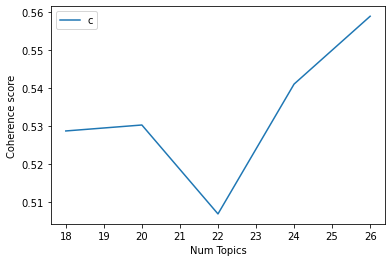

In [31]:
limit=27; start=18; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.5287
Num Topics = 20  has Coherence Value of 0.5303
Num Topics = 22  has Coherence Value of 0.5069
Num Topics = 24  has Coherence Value of 0.5411
Num Topics = 26  has Coherence Value of 0.559


### The optimal number of topics was 25

In [33]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))